# Model Metrics

* **Last Modified**: 07-04-2021
* **Authors**: Sam Budd, Gonzalo Mateo-García
---

This notebook shows how to compute metrics for a trained model on the *WorldFloods* test dataset. The notebook is divided in 4 steps:

1. Load the config file of the experiment.
1. Create a dataloader for the test dataset.
1. Create the segmentation model and load their weights
1. Run inference on all images in the dataset and compute metrics

In [ ]:
!pip install git+https://github.com/spaceml-org/ml4floods#egg=ml4floods

In [1]:
import sys, os
from pathlib import Path

# %load_ext autoreload
# %autoreload 2

## Step 1: Get config

In [3]:
from ml4floods.models.config_setup import get_default_config
from imp import reload

experiment_name = "WFV1_unet"
checkpoint_name = "epoch=24-step=153649.ckpt"

experiment_name = "WFV1_scnn20"
checkpoint_name = "epoch=5-step=24581.ckpt"

# V2 models
# experiment_name = "WF2_unet"
# checkpoint_name = "epoch=5-step=24215.ckpt"

config_fp = f"gs://ml4cc_data_lake/2_PROD/2_Mart/2_MLModelMart/{experiment_name}/config.json"
# config_fp = os.path.join(root, 'src', 'models', 'configurations', 'worldfloods_template.json')
config = get_default_config(config_fp)
config["model_params"]["max_tile_size"] = 1024

Loaded Config for experiment:  WF2_unet
{   'data_params': {   'batch_size': 32,
                       'bucket_id': 'ml4cc_data_lake',
                       'channel_configuration': 'all',
                       'filter_windows': True,
                       'filter_windows_version': 'v2',
                       'input_folder': 'S2',
                       'loader_type': 'local',
                       'num_workers': 4,
                       'path_to_splits': '/worldfloods/v2',
                       'target_folder': 'gt',
                       'train_test_split_file': '0_DEV/2_Mart/worldfloods_v2_0/train_test_split.json',
                       'window_size': [256, 256]},
    'deploy': False,
    'experiment_name': 'WF2_unet',
    'gpus': '0',
    'model_params': {   'hyperparameters': {   'channel_configuration': 'all',
                                               'label_names': [   [   'invalid',
                                                                      'clear',
  

## Step 2: Load dataloader

In [4]:
from ml4floods.models import dataset_setup

config.data_params.loader_type = 'local'
config.data_params.path_to_splits = "worldfloods_v1_sample" # local folder to download the data

config.data_params["download"] = {"train": False, "val": False, "test": True} # download only test data

if "filter_windows" in config["data_params"]:
    del config["data_params"]["filter_windows"]


In [5]:
data_module = dataset_setup.get_dataset(config["data_params"])

Using local dataset for this run
train 196648  tiles
val 1284  tiles
test 11  tiles


In [6]:
dl = data_module.test_dataloader()
# dl = data_module.val_dataloader()

## Step 3: Load a trained model

In [7]:
from ml4floods.models.worldfloods_model import WorldFloodsModel

checkpoint_path = f"gs://ml4cc_data_lake/0_DEV/2_Mart/2_MLModelMart/{experiment_name}/checkpoint/{checkpoint_name}"
model = WorldFloodsModel.load_from_checkpoint(checkpoint_path)

model.to("cuda:1")

WorldFloodsModel(
  (network): UNet(
    (dconv_down1): Sequential(
      (0): Conv2d(13, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), 

## Step 4: Run inference on all the images in the test dataset

In [8]:
from ml4floods.models.model_setup import get_model_inference_function

if config["model_params"].get("model_version","v1") == "v2":
    inf_func = get_model_inference_function(model, config, apply_normalization=False, 
                                        activation="sigmoid")
    print("v2 inference function converted to v1")
    def inference_function(x):
        dual_head_output = inf_func(x)
        B, C, H, W = dual_head_output.shape
        out = torch.zeros((B, 3, H, W),dtype=dual_head_output.dtype)
        out[:, 2] = dual_head_output[:, 0]
        out[:, 1] = (1 - dual_head_output[:, 0]) * dual_head_output[:, 1]
        out[:, 0] = (1 - dual_head_output[:, 0]) * (1 - dual_head_output[:, 1])
        return out
else:
    inference_function = get_model_inference_function(model, config, apply_normalization=False, 
                                                      activation="softmax")

Getting model inference function
Max tile size: 256
v2 inference function converted to v1


100%|██████████| 11/11 [02:29<00:00, 13.58s/it]


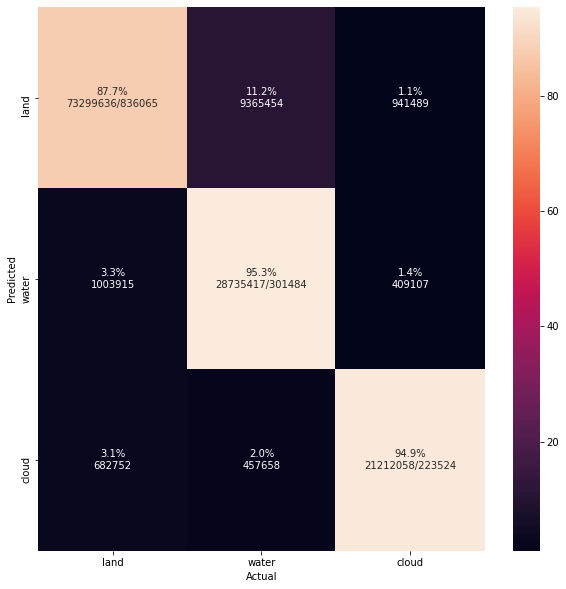

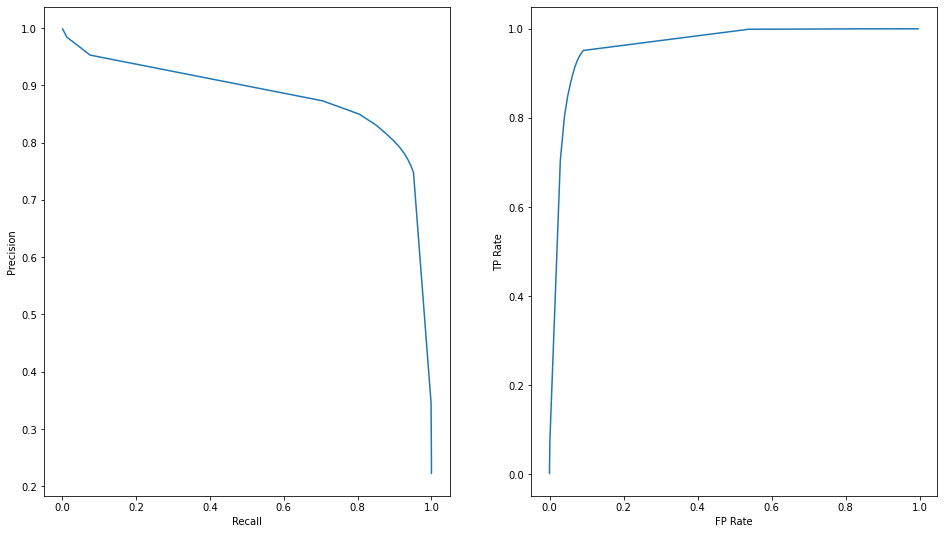

Per Class IOU {
    "cloud": 0.8949078482006331,
    "land": 0.8593838250686562,
    "water": 0.7188967223213759
}


In [9]:
import torch
import numpy as np
import pandas as pd
from ml4floods.models.utils import metrics

# Otherwise fails when reading test dataset from remote bucket
# torch.set_num_threads(1)

thresholds_water = [0,1e-3,1e-2]+np.arange(0.5,.96,.05).tolist() + [.99,.995,.999]

mets = metrics.compute_metrics(
    dl,
    inference_function, 
    thresholds_water=thresholds_water, 
    plot=False)

label_names = ["land", "water", "cloud"]
metrics.plot_metrics(mets, label_names)

## Bonus: Compute the metrics for each flood in the test dataset

In [10]:
CODES_LOC = {"EMSR333": "EMSR333 (Italy)",
             "EMSR9284": "EMSR284 (Finland)",
             "EMSR347": "EMSR347 (Malawi)",
             "EMSR286": "EMSR286 (Colombia)",
             "EMSR342": "EMSR342 (Australia)"
            }

if hasattr(dl.dataset, "image_files"):
    cems_code = [os.path.basename(f).split("_")[0] for f in dl.dataset.image_files]
else:
    cems_code = [os.path.basename(f.file_name).split("_")[0] for f in dl.dataset.list_of_windows]

iou_per_code = pd.DataFrame(metrics.group_confusion(mets["confusions"],cems_code, metrics.calculate_iou,
                                                    label_names=[f"IoU_{l}"for l in ["land", "water", "cloud"]]))

recall_per_code = pd.DataFrame(metrics.group_confusion(mets["confusions"],cems_code, metrics.calculate_recall,
                                                       label_names=[f"Recall_{l}"for l in ["land", "water", "cloud"]]))

join_data_per_code = pd.merge(recall_per_code,iou_per_code,on="code")
join_data_per_code["code"] = join_data_per_code["code"].apply(lambda x: CODES_LOC.get(x,x))
join_data_per_code = join_data_per_code.set_index("code")
join_data_per_code = join_data_per_code*100
print(f"Mean values across flood events: {join_data_per_code.mean(axis=0).to_dict()}")
join_data_per_code

Mean values across flood events: {'Recall_land': 87.33348143096593, 'Recall_water': 92.80309761984151, 'Recall_cloud': 97.00868075669163, 'IoU_land': 85.90695790063388, 'IoU_water': 68.84751663384898, 'IoU_cloud': 50.70366994085482}


,Recall_land,Recall_water,Recall_cloud,IoU_land,IoU_water,IoU_cloud
code,,,,,,
EMSR286 (Colombia),95.278837,97.950186,97.881875,92.935383,81.105355,95.274041
EMSR333 (Italy),89.717028,85.678468,99.150147,88.865142,41.850684,80.932915
EMSR342 (Australia),65.205263,97.213228,94.876355,63.899950,71.252366,89.212278
EMSR347 (Malawi),98.461447,85.206101,93.135027,96.447449,77.177906,88.099116
EMSR284 (Finland),88.004831,97.967505,100.000000,87.386865,72.851272,-100.000000
